## SF Crime Dataset Explorative Data Analysis 


**Explorative Data Analysis (EDA)** is an essential step to ensure validity and applicability of the outcomes data scientists produce. Additionally, it helps data scientists to confirm the right questions to ask. Once EDA is completed, insights can be drawn (e.g. interesting relations, anomalous events). Additionaly, more sophisticated data analysis or modelling (e.g. machine learning, deep learning) can be applied. 


### 1. Introduction 

This project aims to investigate on San Francisco crime data to discover patterns using summary statistics and graphical representations. With such initial exploration, I will be able to understand data distribution, spot anomalies, test initial hypothesis and check assumptions to make sense of data in hand. 

For my second project on the same SF Crime Dataset, I will ustilize the EDA results generated in this project, to perform a K-means clustering and train some machine learning models to predict crimes (e.g. time series analysis). Don't worry, I will upload my project in the coming future. 


### 2. Purpose of Explorative Data Analysis (EDA)
**Objectives**: Using statistics (or cross-tabulation) and graphics 
* To understand variables and find patterns that exist within it.
* To explore relationship between two or more variables 

I have creates a list of questions, answers to which can help me better understand crime data in both structural and contextual respects. I will put down my thoughts underneath my codes. Along with answering these questions, a cleared picture of SF Crimes from 2003 to 2018 will be presented. 

**7 Main Questions to Look at the SF Crime Rates**:
1. Which crime category happened the most/least? 
2. Which district was the safest/most unsafe? 
3. For SF Downtown, how were crime rates in total on different days of a week? 
4. Was there a trend every 12 month (yearly) for crime changes? 
5. Were there "peak hours" for crimes to happen on Christmas/New Year Eve? 
6. Which hours during a day tend to have more crimes? what crimes?
7. How are resolution status for all crime categories? (mostly solved or not?)

### 3. Findings & Solutions
Underneath each question, I put down findings, potential causes and actionable advice for SFPD in the "Remark" section. In the end there is a "Summary" compiling all findings, together with what I believe SFPD could do to better community safety.

Now, let's get started.

### 1. Load Data 

Data used in this project comes from Crime Data Warehouse (www.data.sfgov.org) recording crime records from 2003 January to 2018 May. The records after 2018 May was not included due to a disfunction of the mainframe cable. Up-to-date crime data from May 2018 can be retrieved from another dataset: https://data.sfgov.org/d/wg3w-h783, but I will not include such dataset in EDA at this time. 

Size of Dataset: 550MB (490K Rows, 26 Columns)

In [0]:
from csv import reader
from pyspark.sql import Row
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings
from datetime import datetime
import os
os.environ["PYSPARK_PYTHON"]="python3"

In [0]:
# retrieve data from URL
import urllib.request
urllib.request.urlretrieve("https://data.sfgov.org/api/views/tmnf-yvry/rows.csv?accessType=DOWNLOAD", "/tmp/sf_03_18.csv")

Out[2]: ('/tmp/sf_03_18.csv', <http.client.HTTPMessage at 0x7f230638d370>)

In [0]:
# modify file path 
dbutils.fs.mv("file:/tmp/sf_03_18.csv", "dbfs:/rose/sf_project/data/sf_03_18.csv")

Out[3]: True

In [0]:
# initialize SparkSession SparkSession
from pyspark.sql import SparkSession
spark=SparkSession\
      .builder\
      .appName("SF Crime EDA 03_21")\
      .config("spark.some.config.option", "some-value")\
      .getOrCreate()

In [0]:
# set directory of dataset
data_path="dbfs:/rose/sf_project/data/sf_03_18.csv"

In [0]:
# load data from directory
df= spark.read.format("csv").option("header", "true").load(data_path)

### 2. Explorative Data Analysis (EDA)

To answers the above listed 7 questions, I will utilize Spark Dataframe to look into data structure and try to extract insights using both non-graphical and graphical analysis.

#### Q1: Which crime category happened the most/least?

In [0]:
q1=df.groupBy("Category").count().orderBy("count", ascending=False)
display(q1)

Category,count
LARCENY/THEFT,477975
OTHER OFFENSES,301874
NON-CRIMINAL,236928
ASSAULT,167042
VEHICLE THEFT,126228
DRUG/NARCOTIC,117821
VANDALISM,114718
WARRANTS,99821
BURGLARY,91067
SUSPICIOUS OCC,79087


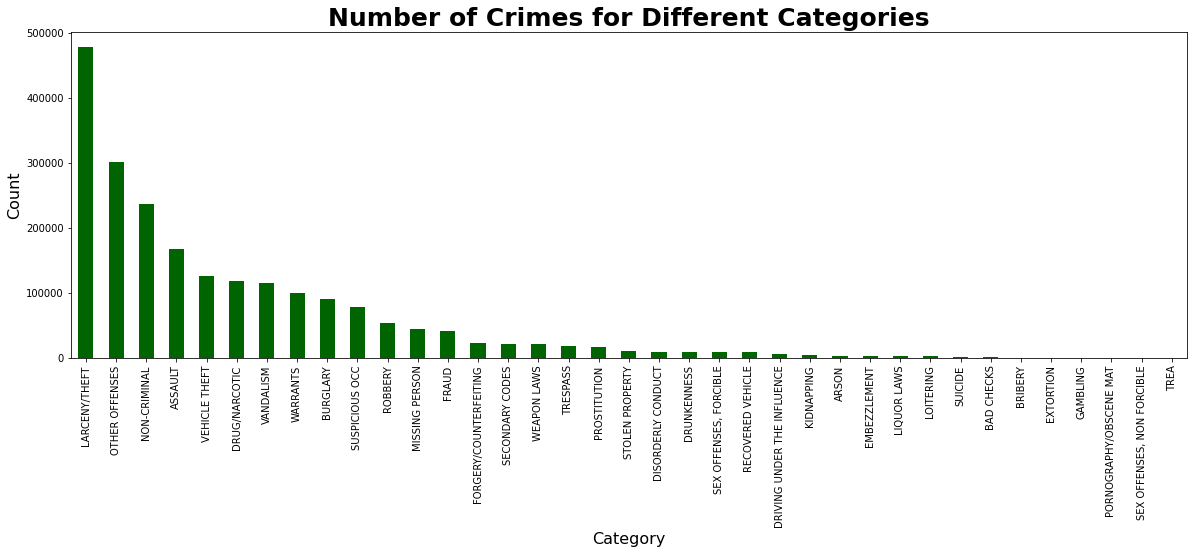

In [0]:
# visualization
import matplotlib.pyplot as plt
import numpy as np
q1_pd=q1.toPandas()
plt.figure() 
ax=q1_pd.plot(kind="bar", x="Category", y="count", figsize=(20,6),color="darkgreen", legend=False) 
ax.set_xlabel("Category", fontsize=16)
ax.set_ylabel("Count", fontsize=16) 
plt.title("Number of Crimes for Different Categories", fontsize=25, fontweight="bold") 
pos=np.arange(1,38)
ax.set_xticks(np.arange(37)) 
ax.set_xticklabels(q1_pd.Category)
display()

**Q1 Insights**: <br/>
As shown in the bar chart, among all crime cases that SFPD received 
* Larceny/Theft was most reported
* Trea was least reported 
* Non-forcible Sex Offense and Pornography/Obscene were #2, #3 least category

ps. TREA refers to "trespassing or loirtering near posted industrial propert"

#### Q2: Which district was the safest/most unsafe?

In [0]:
q2=df.groupBy("PdDistrict").count().orderBy("count", ascending=False)
display(q2)

PdDistrict,count
SOUTHERN,390692
MISSION,288985
NORTHERN,266435
CENTRAL,221923
BAYVIEW,205480
TENDERLOIN,186954
INGLESIDE,181092
TARAVAL,155461
PARK,119698
RICHMOND,112804


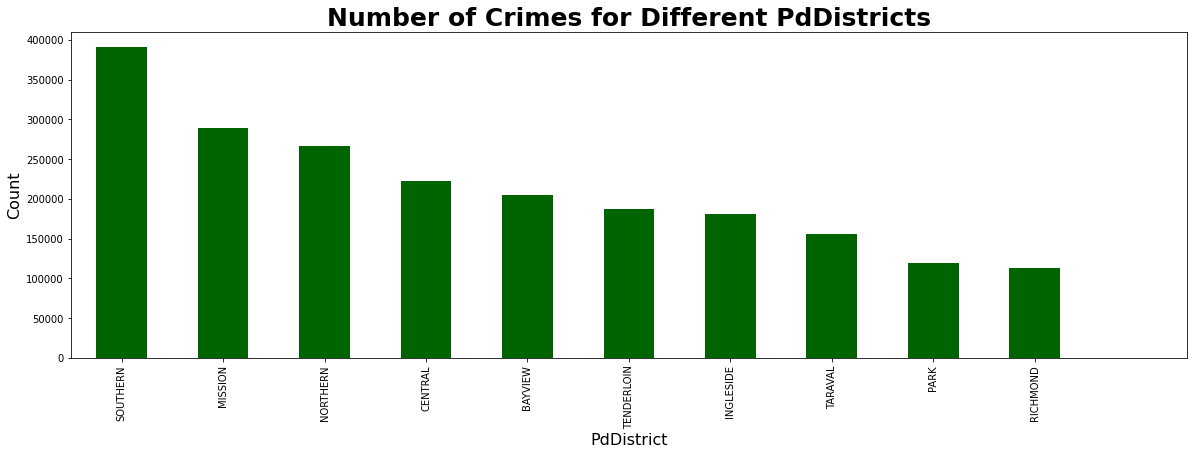

In [0]:
q2_pd=q2.toPandas()
figure, ax=plt.subplots(figsize=(20,6))
q2_pd.plot(kind="bar", x="PdDistrict", y="count", color="darkgreen", legend=False, ax=ax)
ax.set_xlabel("PdDistrict", fontsize=16)
ax.set_ylabel("Count", fontsize=16)
plt.xticks(np.arange(10))
plt.title("Number of Crimes for Different PdDistricts", fontsize=25, fontweight="bold")
plt.show()

**Q2 Insights**: <br/>
As indicated in the bar chart, among 10 SF districts 
* Richmond had least crime reported
  * Park had the second least reported crimes
* Southern had most crime archived in SFPD (~3X Richmond)
* Mission, Northern and Central all had relatively high crime rates

#### Q3: For SF Downtown, how were crime rates in total on different days of a week?

In [0]:
# convert longitude (X) and Lattitude (Y) from string into float
df=df.withColumn("X", df.X.cast("float")).withColumn("Y", df.Y.cast("float"))

In [0]:
# I eliminated (-120.5,90) as it is too far away from other locations in SF
df=df.filter((df.X != -120.5)&(df.Y != 90))

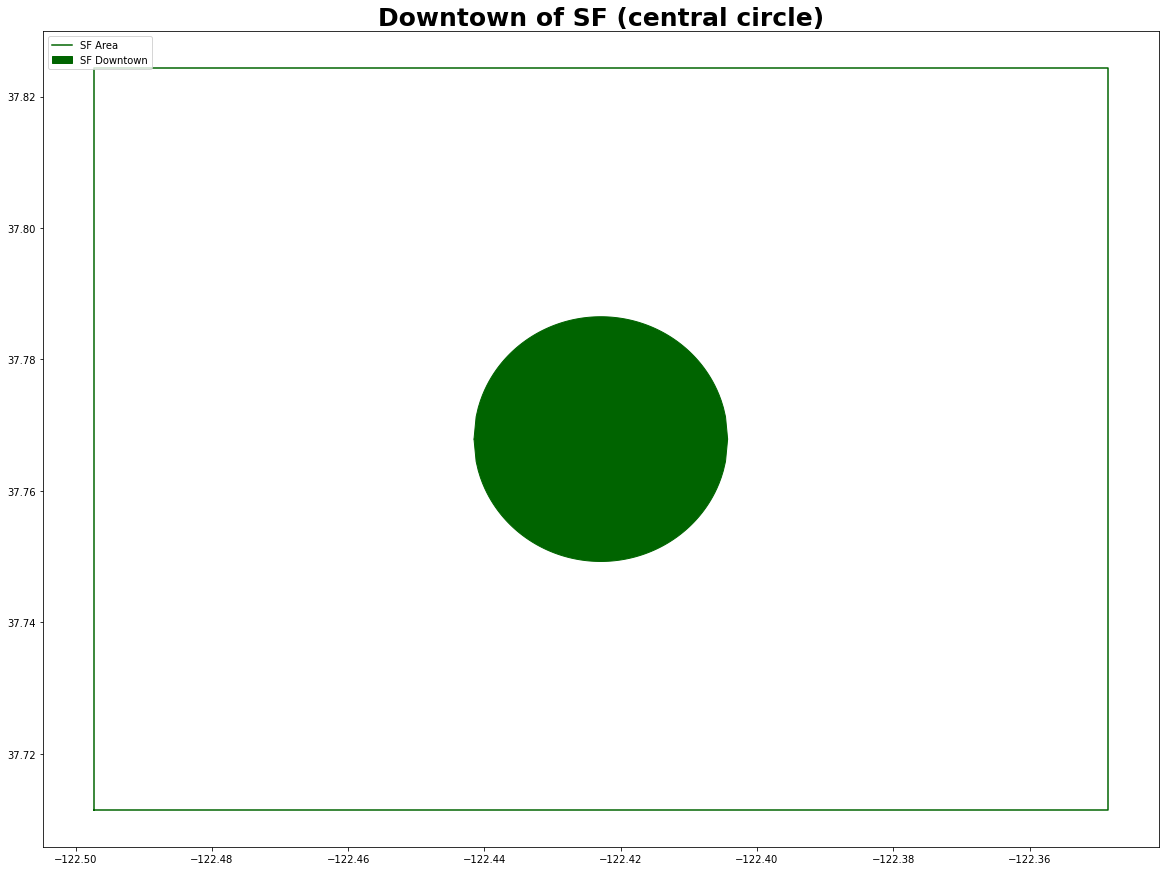

In [0]:
# visualize downtown area
x= df.select(avg("X")).collect()[0][0]
y= df.select(avg("Y")).collect()[0][0]

rangeX=df.select(max("X")).collect()[0][0] - df.select(min("X")).collect()[0][0]
rangeY=df.select(max("Y")).collect()[0][0] - df.select(min("Y")).collect()[0][0]

rectX=[x-rangeX/2, x+rangeX/2, x+rangeX/2,x-rangeX/2,x-rangeX/2]
rectY=[y-rangeY/2, y-rangeY/2, y+rangeY/2, y+rangeY/2,y-rangeY/2]

r=rangeX/8
dtrectX=list(np.linspace(x-r, x+r,120))
dtrectY=[(r**2-( _- x)**2)**0.5 + y for _ in dtrectX] + [-(r**2-( _- x)**2)**0.5 + y for _ in dtrectX]

plt.figure(figsize=(20,15))
plt.plot(rectX, rectY, color="darkgreen")
plt.fill(dtrectX*2,dtrectY, color="darkgreen")
plt.legend(("SF Area", "SF Downtown"), loc="upper left")
plt.title("Downtown of SF (central circle)",fontsize=25,fontweight="bold")
plt.show()

In [0]:
# define a downtown filter
def downtown_filter(x,y):
  center_x=-122.42309201703928
  center_y= 37.768722108336846
  r= 0.01854991912841797
  if (x-center_x)**2+(y-center_y)**2<r**2:
    return True
  else:
    return False
  
dt_filter=udf(downtown_filter, BooleanType())

# group crimes into downtown and non downtown
df=df.withColumn("isDownTown", dt_filter("X", "Y"))

In [0]:
# define a datetime transformer
date_func=udf(lambda x: datetime.strptime(x, "%m/%d/%Y"), DateType()) 

# convert date from string to timestamp
df=df.withColumn("dte", date_func(col("Date")))

In [0]:
# extract day of week information from timestamp
df=df.withColumn("DoW", dayofweek(col("dte")))

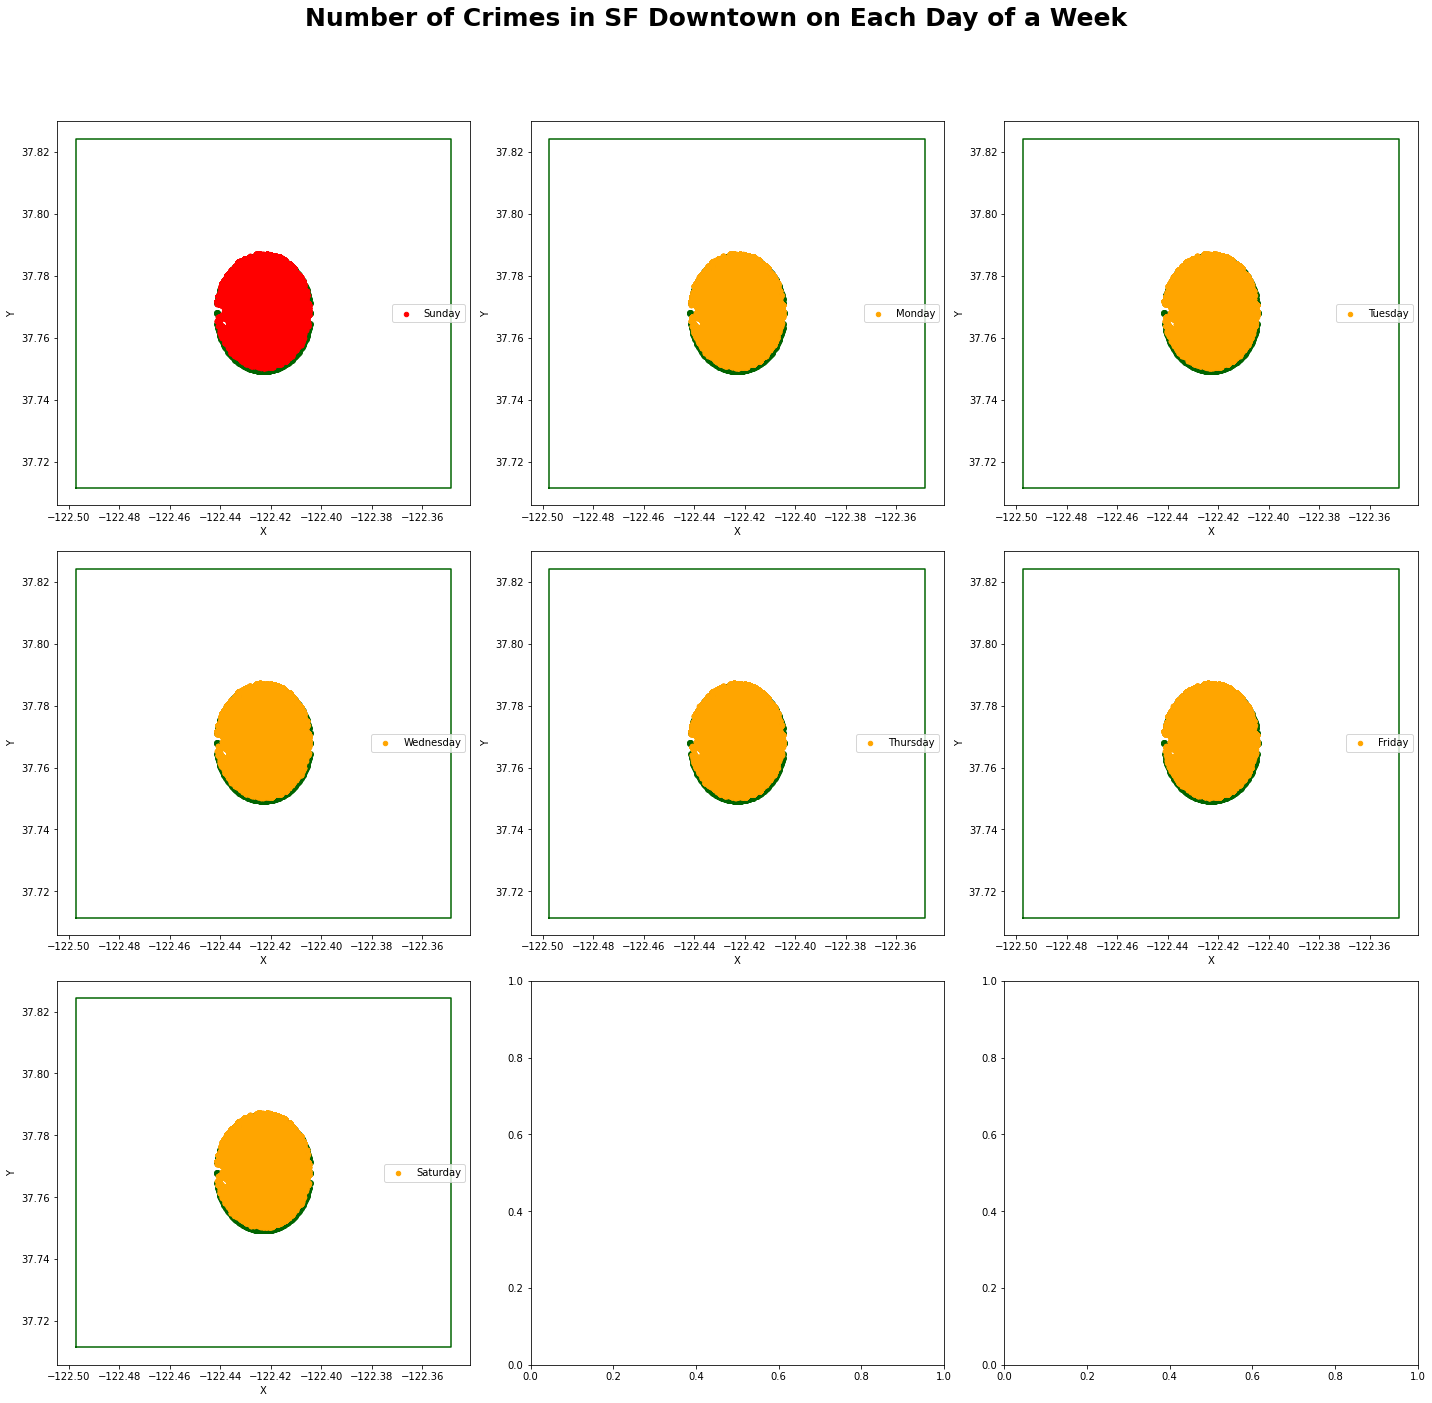

In [0]:
# retrieve downtown crime data
dt_pd=df.filter(df.isDownTown==True).toPandas()

# group downtown crime data by day of week 
q3=df.filter(df.isDownTown==True).groupBy("DoW").count().orderBy("DoW", ascending=True)

# visualize downtown crimes by day of week 
fig, axes=plt.subplots(3,3, figsize=(20,18))
n=3
colors=["red", "orange","orange","orange","orange","orange","orange"]
dow=["Sunday", "Monday","Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
for i in range(7):
  temp_ax=axes[i//n, i%n]
  temp_ax.plot(rectX, rectY, color="darkgreen")
  temp_ax.scatter(dtrectX*2, dtrectY, color="darkgreen")
  # 1-Sunday, 2-Monday,...7-Saturday
  dt_pd.loc[dt_pd["DoW"]==i+1].plot(kind="scatter", x="X", y="Y", color=colors[i], ax=temp_ax, label=dow[i])
  temp_ax.legend()

plt.suptitle("Number of Crimes in SF Downtown on Each Day of a Week", fontsize=25, fontweight="bold",y=1.08)

plt.tight_layout()
plt.show()

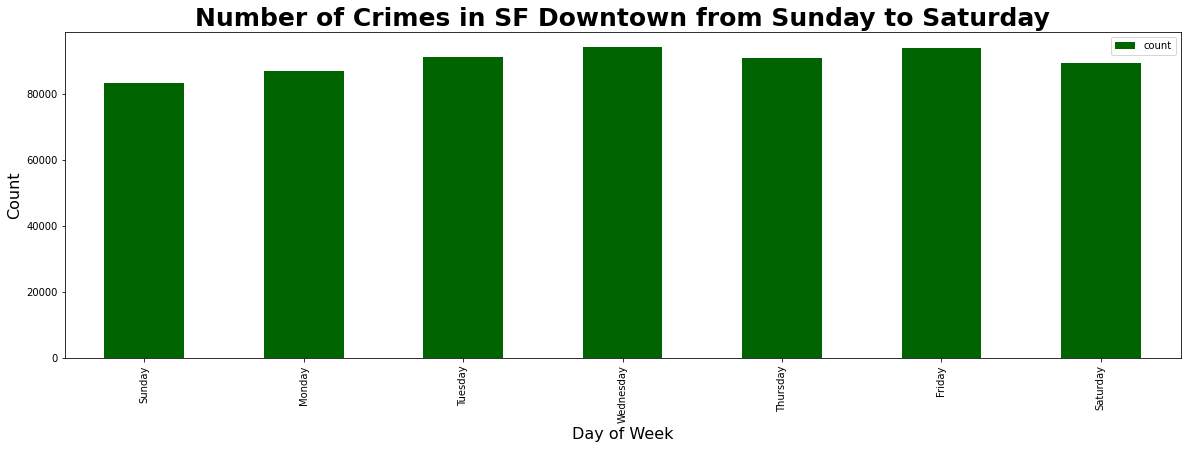

In [0]:
q3_pd=q3.toPandas()
fig, ax=plt.subplots(figsize=(20,6))
q3_pd.plot(kind="bar", x="DoW", y="count", color="darkgreen", ax=ax)
ax.set_xlabel("Day of Week", fontsize=16)
ax.set_ylabel("Count", fontsize=16)
ax.set_xticklabels(dow)
plt.title("Number of Crimes in SF Downtown from Sunday to Saturday", fontsize=25, fontweight="bold")
plt.show()

**Q3 Insights**: <br/>
As illustrated in the bar chart, number of crimes reported in SF downtown
* slightly lower on weekends
* relatively higher on Wednesday and Friday
* geographically, less crimes in the southern part of downtown 

There is one spot (southwest) where none of crimes occurred. Chances are that it is where the distict police station was located)

#### Q4: Was there a trend every 12 month (yearly) for crime changes?

In [0]:
# extract month, year from datetime
df=df.withColumn("Year", year(col("dte"))).withColumn("Month", month(col("dte")))

# extract year-month combo from datetime
yrmo_func=udf(lambda x: datetime.strftime(x, "%Y/%m"), StringType())
df=df.withColumn("YrMo", yrmo_func(col("dte")))

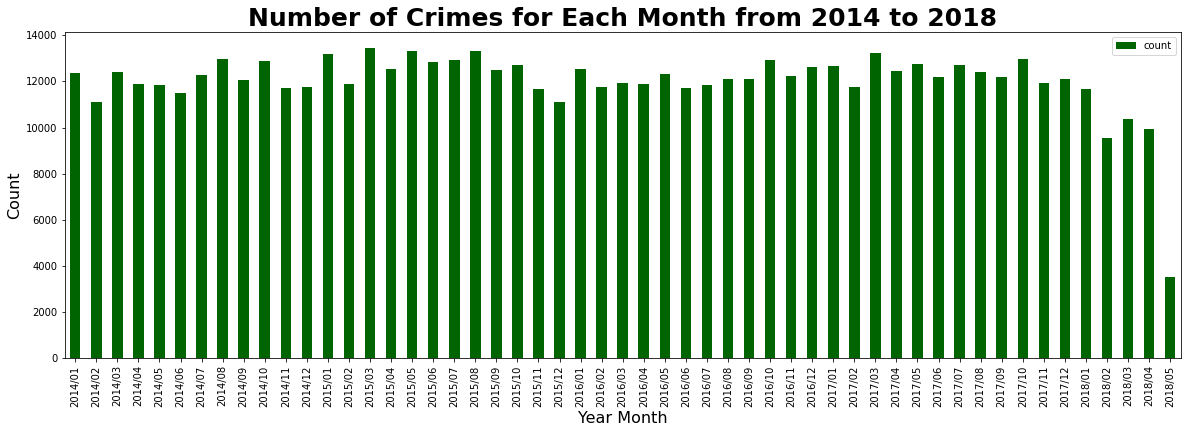

In [0]:
# visualize year_month from 2014 to 2018
fig, ax=plt.subplots(figsize=(20,6))
q4=df.filter(df.Year>=2014).groupBy("YrMo").count().orderBy("YrMo")
q4_pd=q4.toPandas()
q4_pd.plot(kind="bar", x="YrMo", y="count", color="darkgreen", ax=ax)
plt.title("Number of Crimes for Each Month from 2014 to 2018", fontweight="bold", fontsize=25)
ax.set_xlabel("Year Month", fontsize=16)
ax.set_ylabel("Count", fontsize=16)
plt.show()


In [0]:
q_=df.groupBy("YrMo").count().orderBy("YrMo")
display(q_)

YrMo,count
2003/01,12366
2003/02,11376
2003/03,12400
2003/04,12249
2003/05,12040
2003/06,11444
2003/07,11888
2003/08,12386
2003/09,12208
2003/10,12466


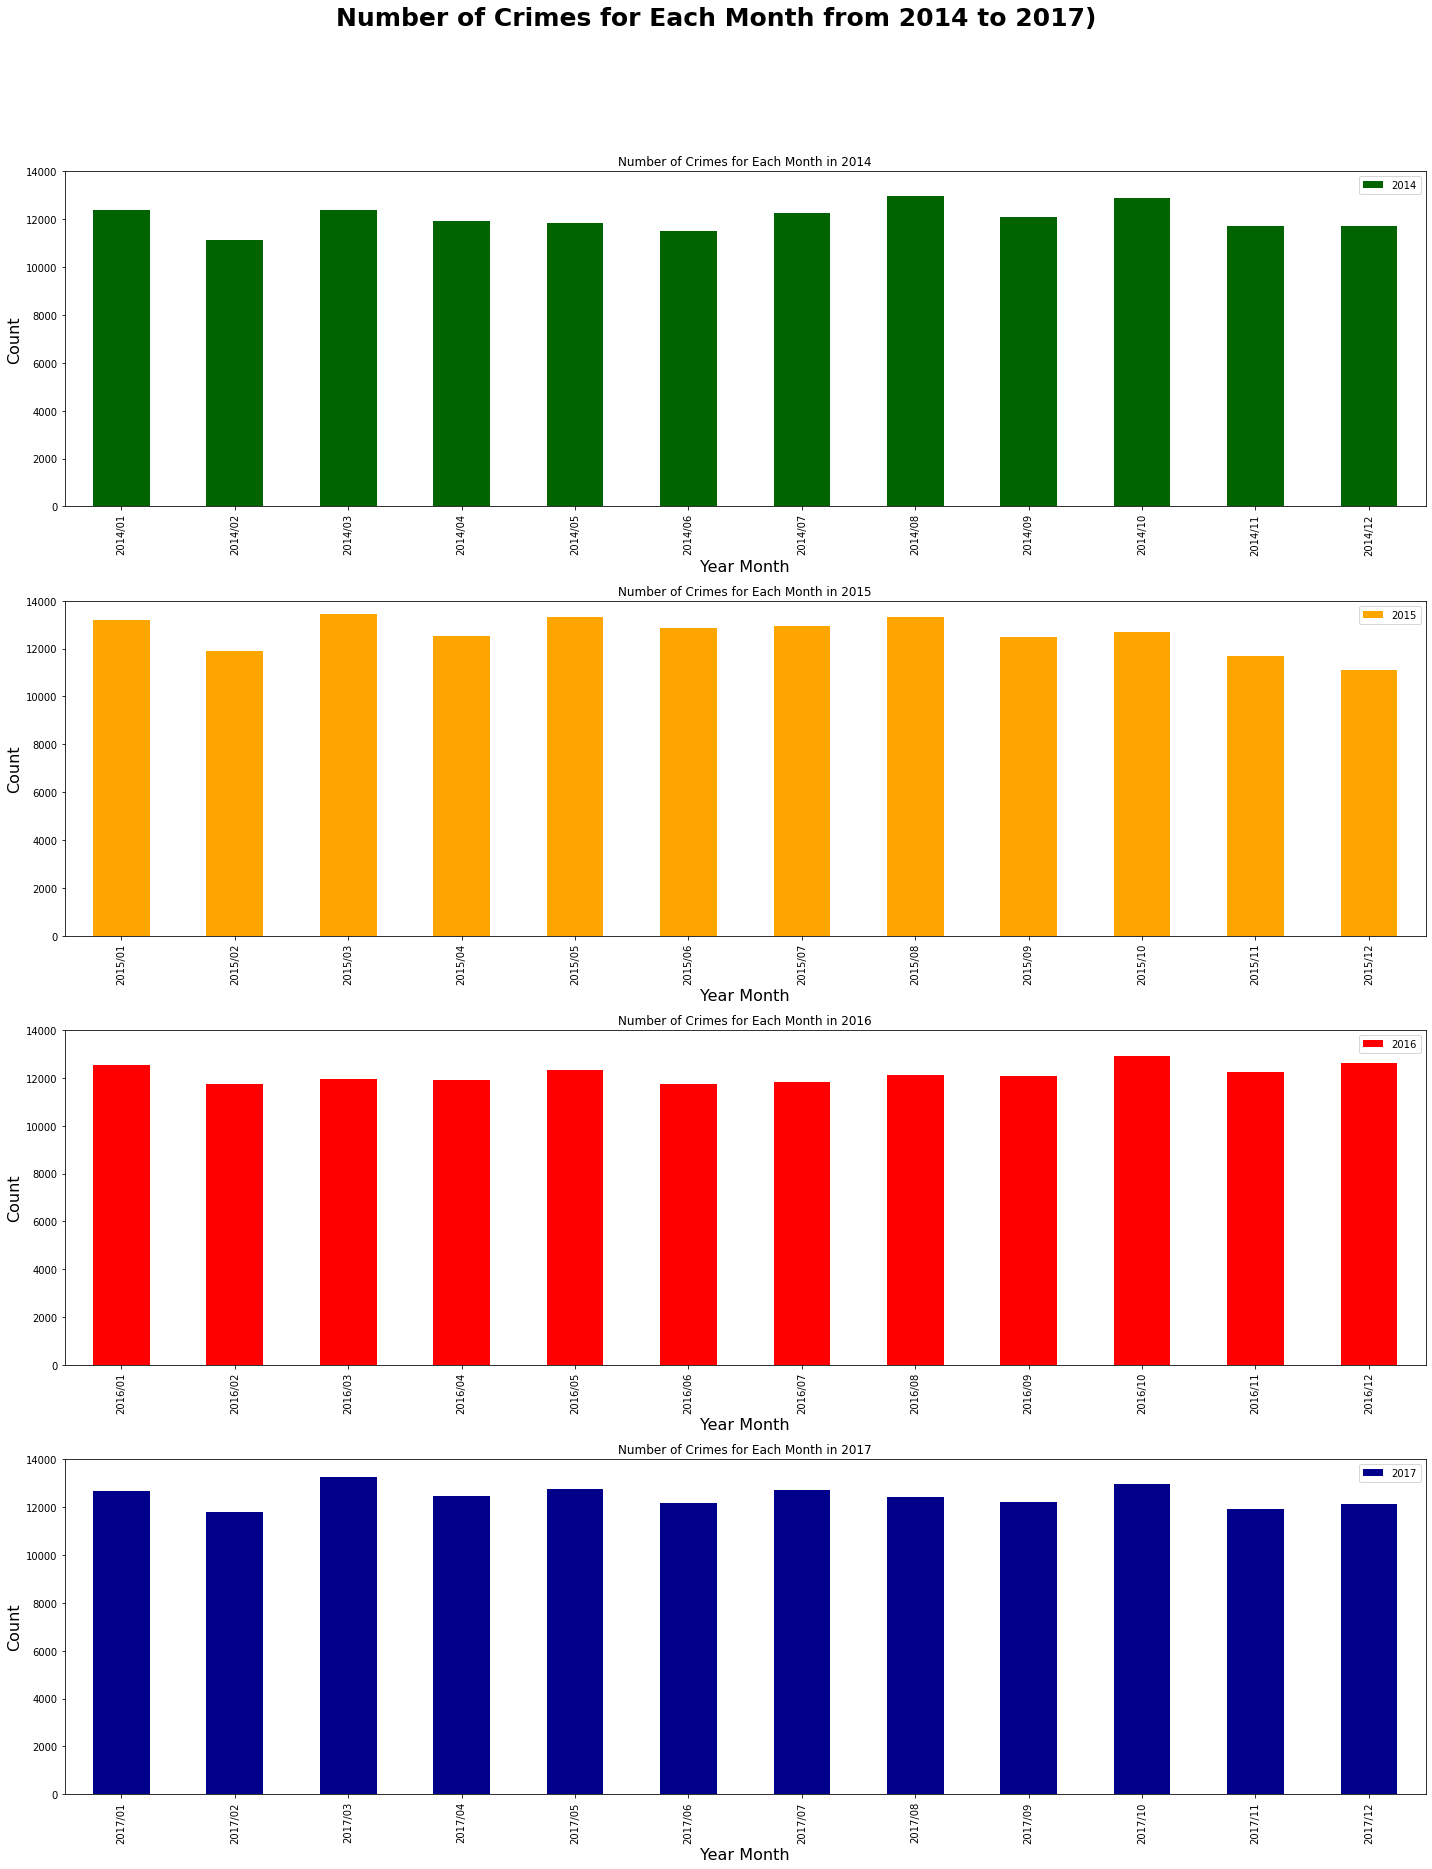

In [0]:
# extract data from 2014 to 2017 to check if there is seasonal trend each year
q4_14=df.filter(df.Year== 2014). groupBy("YrMo").count().orderBy("YrMo").toPandas()
q4_15=df.filter(df.Year== 2015). groupBy("YrMo").count().orderBy("YrMo").toPandas()
q4_16=df.filter(df.Year== 2016). groupBy("YrMo").count().orderBy("YrMo").toPandas()
q4_17=df.filter(df.Year== 2017). groupBy("YrMo").count().orderBy("YrMo").toPandas()

fig, axes=plt.subplots(4,1,figsize=(20,24))
years=[2014,2015,2016,2017]
data=[q4_14,q4_15, q4_16,q4_17]
colors=["darkgreen", "orange", "red", "darkblue"]
for i in range(4):
  temp_ax=axes[i]
  data[i].plot(kind="bar", x="YrMo", y="count", color=colors[i], label=str(years[i]),ax=temp_ax)
  temp_ax.set_xlabel("Year Month", fontsize=16)
  temp_ax.set_ylabel("Count", fontsize=16)
  temp_ax.set_title("Number of Crimes for Each Month in {}".format(str(years[i])))
  temp_ax.set_ylim(0,14000)

plt.suptitle("Number of Crimes for Each Month from 2014 to 2017)", fontsize=25, fontweight="bold",y=1.08)
plt.tight_layout()
plt.show()

**Q4 Insights**: <br/>
As illustrated in the first bar chart, number of crimes for each month in SF from 2014 to 2018: 
* dropped significantly since 2018 January
* increased sharply in 2015 January

As shown in the second bar charts, there seemed to exist some seasonal patterns for crime rates. For example, crime rates seemed to :
* before 2016
  * significantly increased in 2015
  * increased at the beginning of the year
  * decreased near the end of the Summer (August) til its year end
* 2016 and after
  * stayed high in Q1 and Q4
  * remained steady and controlled in the middle of the year
  * significantly dropped in 2018

#### Q5: Were there "peak hours" for crimes to happen on Christmas/New Year Eve?

In [0]:
# define Christmas from 12/24 to 12/25 and New Year Eva from 12/31 to 1/1
# extract hour from time
def time_to_hour(x):
  return x.split(":")[0]
t2h=udf(lambda x: time_to_hour(x), StringType())

df=df.withColumn("Hour", t2h(col("Time")))

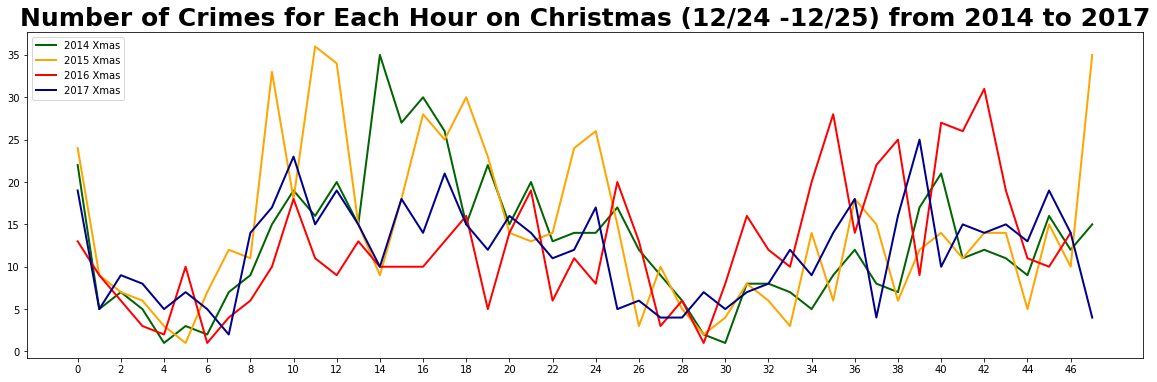

In [0]:
# visualize crime rates on Christmas
dates=[["12/24/2014","12/25/2014"],["12/24/2015","12/25/2015"],["12/24/2016", "12/25/2016"],["12/24/2017","12/25/2017"]]

fig, ax=plt.subplots(figsize=(20,6))
colors=["darkgreen", "orange", "red", "darkblue"]
labels=["2014 Xmas", "2015 Xmas", "2016 Xmas", "2017 Xmas"]
for i in range(4):
  q5=df[df.Date.isin(dates[i])].groupBy("DoW","Hour").count().orderBy("Dow","Hour")
  q5_pd=q5.toPandas()
  plt.plot(np.arange(len(q5_pd.index)),q5_pd["count"],color=colors[i], linewidth=2, label=labels[i])
ax.set_xticks(np.arange(24)+np.arange(24))
plt.title("Number of Crimes for Each Hour on Christmas (12/24 -12/25) from 2014 to 2017", fontsize=25, fontweight="bold")
plt.legend()
plt.show()

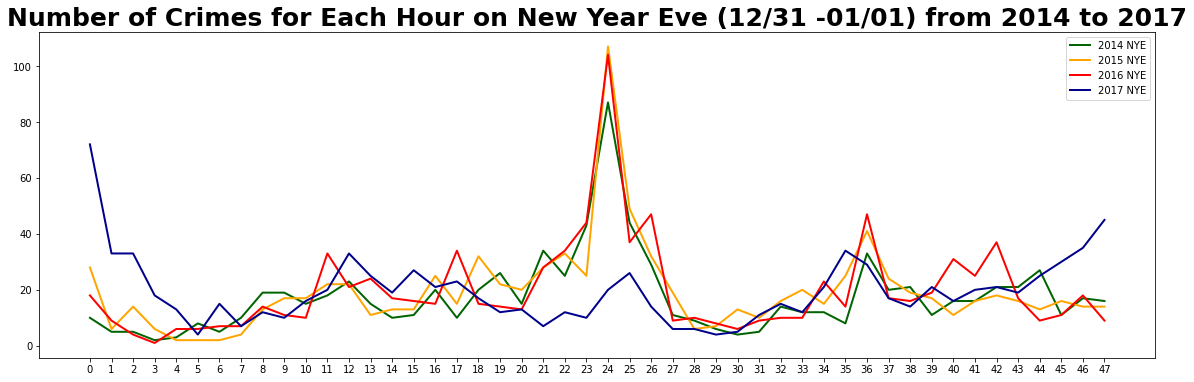

In [0]:
# visualize crime rates on New Year Eve
dates=[["12/31/2013","01/01/2014"],["12/31/2014","01/01/2015"],["12/31/2015", "01/01/2016"],["12/31/2016","01/01/2017"]]

fig, ax=plt.subplots(figsize=(20,6))
colors=["darkgreen", "orange", "red", "darkblue"]
labels=["2014 NYE", "2015 NYE", "2016 NYE", "2017 NYE"]
for i in range(4):
  q5=df[df.Date.isin(dates[i])].groupBy("DoW","Hour").count().orderBy("Dow","Hour")
  q5_pd=q5.toPandas()
  plt.plot(np.arange(len(q5_pd.index)),q5_pd["count"],color=colors[i], linewidth=2, label=labels[i])
ax.set_xticks(np.arange(48))
plt.title("Number of Crimes for Each Hour on New Year Eve (12/31 -01/01) from 2014 to 2017", fontsize=25, fontweight="bold")
plt.legend()
plt.show()

**Q5 Insights**: <br/>
As illustrated in the first bar chart, number of crimes for each hour in SF from on **Christmas** (12/24 to 12/25): 
* started to increas from 8am and reached to a peak at noon (12pm) on 12/24 
* increased from 8am to 8pm on 12/25, but less significanly compared to 12/24
* remained low at midnight and in the morning before 8am
* Safty advice could be given to citizens, such as being more aware of their safety and belongings when shopping or celebrating with their family.


As illustrated in the second bar chart, number of crimes for each hour in SF from on **New Year Eve** (12/31 to 01/01): 
* increased sharply from 8pm (12/31) to 4am (01/01)
* reached at the peak during midnight of New Year's Eve (01/01)
* remained low in the morning of 01/01 but rose after 8am (01/01)
* Citizens shall be advised to stay at home to keep their safety

#### Q6: Which hours during a day tend to have more crimes? what crimes?

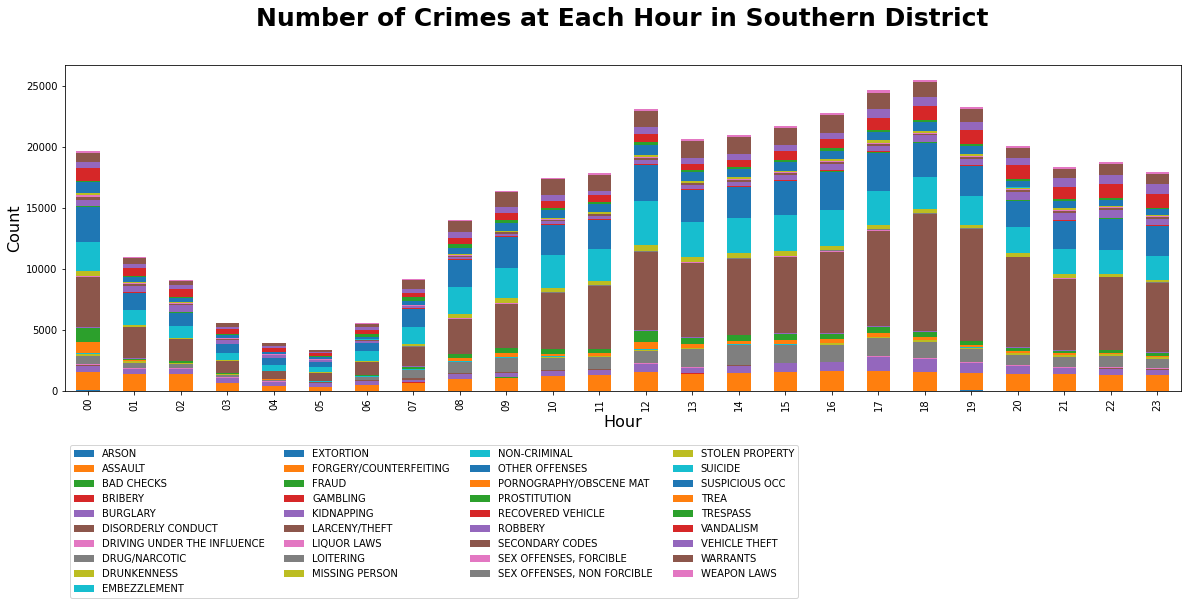

In [0]:
# First look at Southern 
# Top 3 Unsafe Districts: Southern > Mission > Northern
q6_s=df.filter(df.PdDistrict == "SOUTHERN").groupBy("Hour").pivot("Category").count().orderBy("Hour")
q6_s_pd=q6_s.toPandas()

# visualize crimes rates for different category at specific hour (Southern)
fig, ax=plt.subplots(figsize=(20,6))
q6_s_pd.plot.bar(x="Hour",stacked=True, ax=ax)
ax.set_xlabel("Hour", fontsize=16)
ax.set_ylabel("Count", fontsize=16)
plt.title("Number of Crimes at Each Hour in Southern District", fontsize=25, fontweight="bold", y=1.10)
plt.legend(ncol=4, bbox_to_anchor=[0,-0.15],loc="upper left")
plt.show()


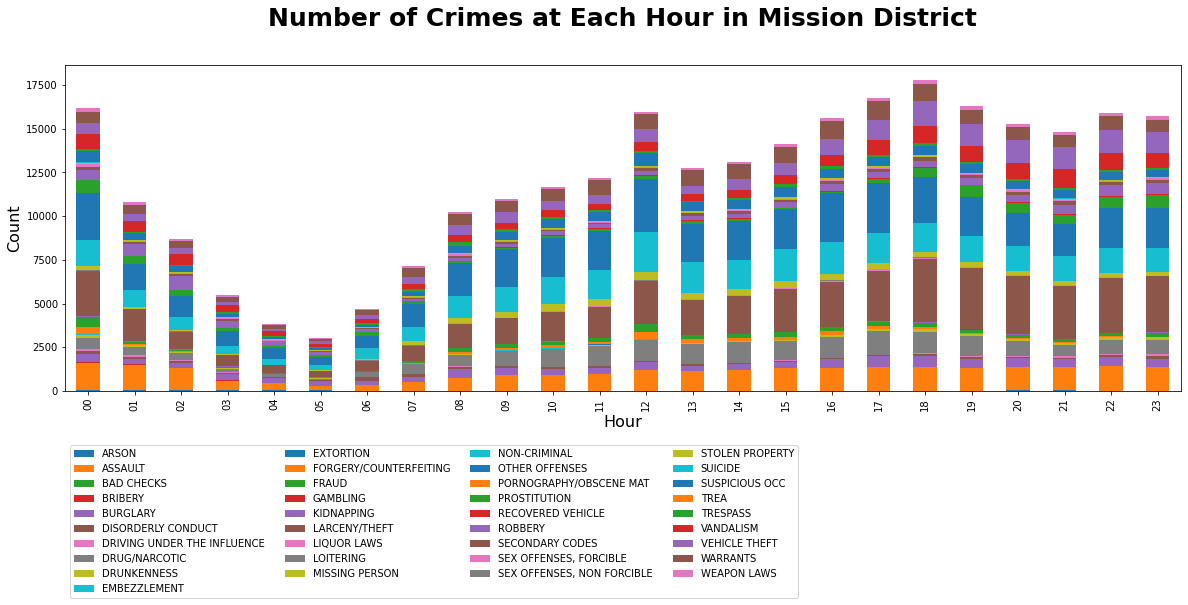

In [0]:
# Look at Mission district
q6_m=df.filter(df.PdDistrict == "MISSION").groupBy("Hour").pivot("Category").count().orderBy("Hour")
q6_m_pd=q6_m.toPandas()

fig, ax=plt.subplots(figsize=(20,6))
q6_m_pd.plot.bar(x="Hour",stacked=True, ax=ax)
ax.set_xlabel("Hour", fontsize=16)
ax.set_ylabel("Count", fontsize=16)
plt.title("Number of Crimes at Each Hour in Mission District", fontsize=25, fontweight="bold", y=1.10)
plt.legend(ncol=4, bbox_to_anchor=[0,-0.15],loc="upper left")
plt.show()

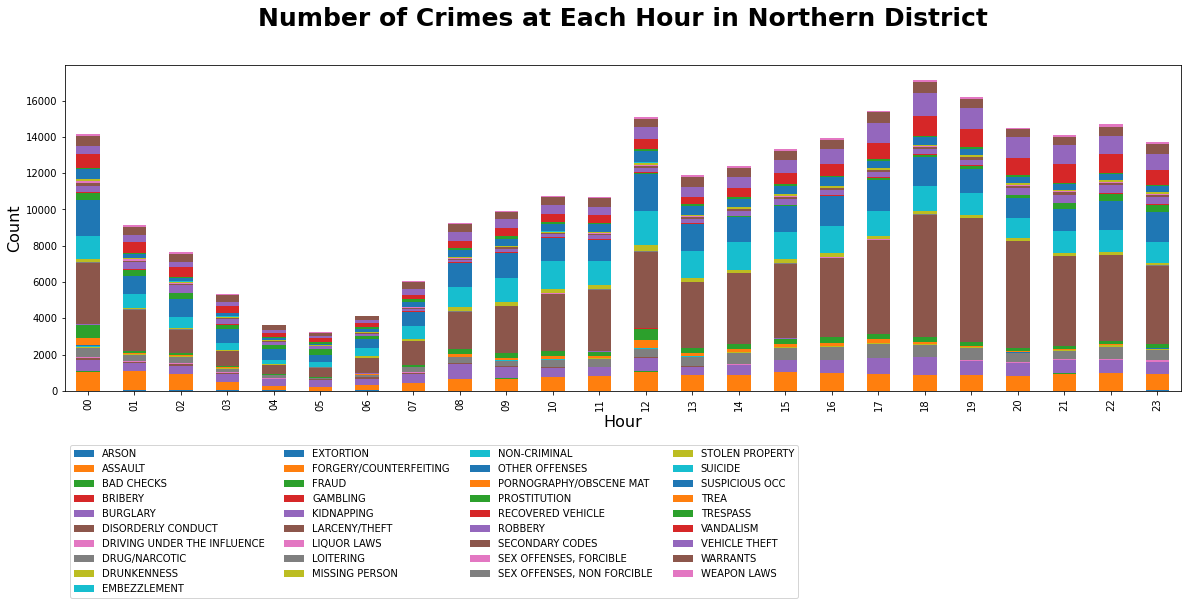

In [0]:
# Look at Northern district
q6_n=df.filter(df.PdDistrict == "NORTHERN").groupBy("Hour").pivot("Category").count().orderBy("Hour")
q6_n_pd=q6_n.toPandas()

fig, ax=plt.subplots(figsize=(20,6))
q6_n_pd.plot.bar(x="Hour",stacked=True, ax=ax)
ax.set_xlabel("Hour", fontsize=16)
ax.set_ylabel("Count", fontsize=16)
plt.title("Number of Crimes at Each Hour in Northern District", fontsize=25, fontweight="bold", y=1.10)
plt.legend(ncol=4, bbox_to_anchor=[0,-0.15],loc="upper left")
plt.show()

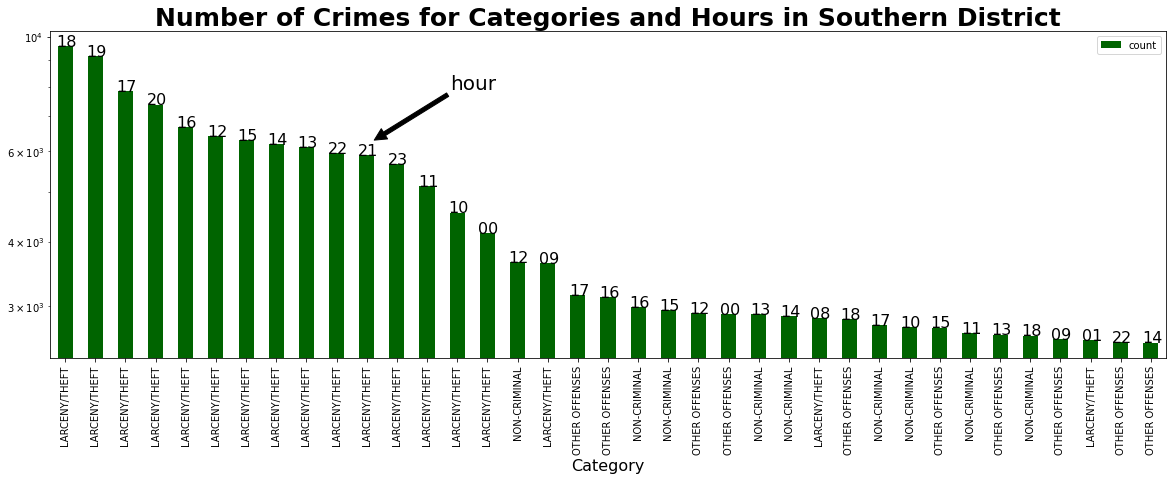

In [0]:
# Check crimes of category and hour in Southern district
q6_sc=df.filter(df.PdDistrict=="SOUTHERN").groupBy("Category","Hour").count().orderBy("count", ascending=False)
# eliminate category at hours with less than or equal to 2500
q6_sc_pd=q6_sc.filter(q6_sc["count"]>2500).toPandas()

# visualize category and hour based on crime numbers in a descending order
fig, ax=plt.subplots(figsize=(20,6))
q6_sc_pd.plot(kind="bar", x="Category", y="count", logy=True, color="darkgreen", ax=ax)

# specify the nature of annotations and its position
hours=[row["Hour"] for row in q6_sc.select("Hour").collect()]
x_offset=-0.3
y_offset=0.5

for k,p in enumerate(ax.patches):
  b=p.get_bbox()
  val=hours[k]
  # annotate exact hour on top of each bar
  words=ax.annotate(str(val), ((b.x0+b.x1)/2+x_offset, b.y1+y_offset))
  words.set_fontsize(16)


text=ax.annotate('hour', xy=(10.25,6297), xytext=(12.75,7897),arrowprops=dict(facecolor='black', shrink=3))
text.set_fontsize(20)

ax.set_xlabel("Category", fontsize=16)
plt.title("Number of Crimes for Categories and Hours in Southern District", fontsize=25, fontweight="bold")

plt.show()

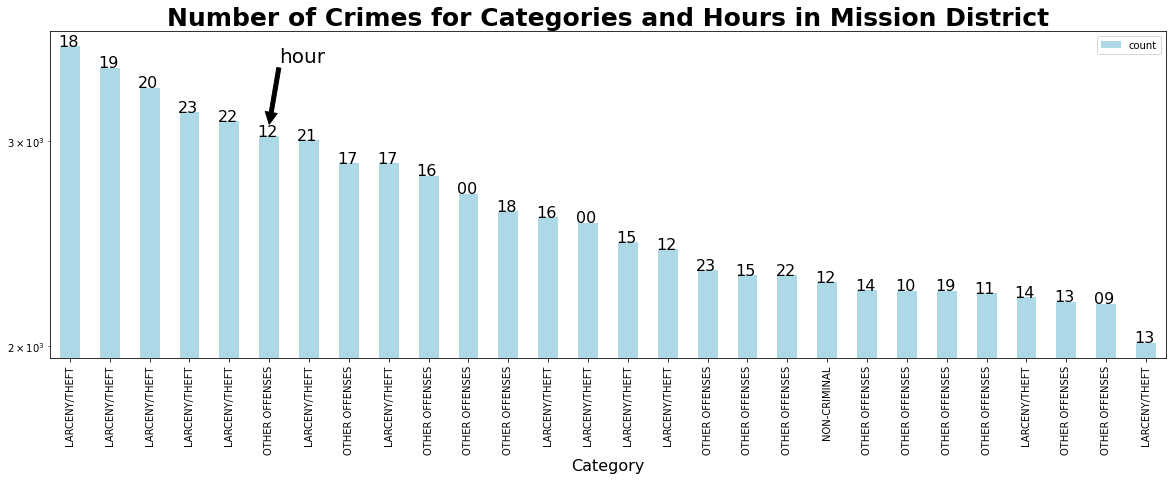

In [0]:
# Check crimes of category and hour in Mission district
q6_mc=df.filter(df.PdDistrict=="MISSION").groupBy("Category","Hour").count().orderBy("count", ascending=False)
# eliminate category at hours with less than or equal to 2000
q6_mc_pd=q6_mc.filter(q6_mc["count"]>2000).toPandas()

# visualize category and hour based on crime numbers in a descending order
fig, ax=plt.subplots(figsize=(20,6))
q6_mc_pd.plot(kind="bar", x="Category", y="count", logy=True, color="lightblue", ax=ax)

# specify the nature of annotations and its position
x_offset=-0.3
y_offset=0.5
hours=[row["Hour"] for row in q6_mc.select("Hour").collect()]

for k,p in enumerate(ax.patches):
  b=p.get_bbox()
  val=hours[k]
  # annotate exact hour on top of each bar
  words=ax.annotate(str(val), ((b.x0+b.x1)/2+x_offset, b.y1+y_offset))
  words.set_fontsize(16)

text=ax.annotate('hour', xy=(5.0,3100), xytext=(5.25,3507),arrowprops=dict(facecolor='black', shrink=3))
text.set_fontsize(20)

ax.set_xlabel("Category", fontsize=16)
plt.title("Number of Crimes for Categories and Hours in Mission District", fontsize=25, fontweight="bold")

plt.show()

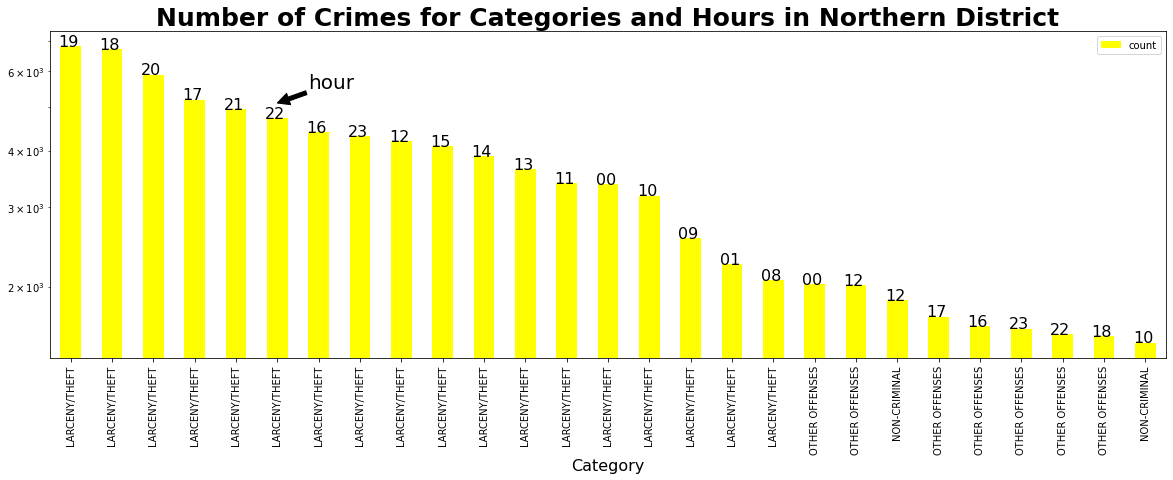

In [0]:
# Check crimes of category and hour in Northern district
q6_nc=df.filter(df.PdDistrict=="NORTHERN").groupBy("Category","Hour").count().orderBy("count", ascending=False)
# eliminate category at hours with less than or equal to 1500
q6_nc_pd=q6_nc.filter(q6_nc["count"]>1500).toPandas()

# visualize category and hour based on crime numbers in a descending order
fig, ax=plt.subplots(figsize=(20,6))
q6_nc_pd.plot(kind="bar", x="Category", y="count", logy=True, color="yellow", ax=ax)

# specify the nature of annotations and its position
x_offset=-0.3
y_offset=0.5
hours=[row["Hour"] for row in q6_nc.select("Hour").collect()]

for k,p in enumerate(ax.patches):
  b=p.get_bbox()
  val=hours[k]
  # annotate exact hour on top of each bar
  words=ax.annotate(str(val), ((b.x0+b.x1)/2+x_offset, b.y1+y_offset))
  words.set_fontsize(16)

text=ax.annotate('hour', xy=(5.0,5100), xytext=(5.75,5507),arrowprops=dict(facecolor='black', shrink=3))
text.set_fontsize(20)

ax.set_xlabel("Category", fontsize=16)
plt.title("Number of Crimes for Categories and Hours in Northern District", fontsize=25, fontweight="bold")

plt.show()

**Q6 Insights**: <br/>
As illustrated in stacked bar charts, I checked the number of crimes for each month in top 3 most unsafe districts (Southern > Mission > Northern) in SF and found:
* **safest hour in 3 districts**: 5am 
* **unsafe hours in 3 districts**: 12pm, 5pm to 7pm, midnight (12am) 
* **periods when crime rates increased linearly in 3 districts**: from 5am to 6pm

The bar charts looked into number of categories and hours in top 3 most unsafe distrcits (Southern > Mission > Northern) in SF, there are some noticable findings:
* ** Southern**: 
  * I filtered out crime categories that happend less than 2500 times for visualization purpose
  * Lacerny/Theft was the #1 crime and mostly happened at evening, often witnessed from 4pm to 8pm. 
  * Non-Criminal and Other Offenses were the #2, #3 crime and most frequently witnessed on noon (12pm) and late afternoon (4pm to 6pm)
* ** Mission**:
  * I filtered out crime categories that happended less than 2000 times for visualization purpose
  * Lacerny/Theft was the #1 crime and mostly happened at evening, often witnessed from 6pm to 11pm. 
  * Other Offenses was the #2 crime, most occured on noon (12pm), midnight (12am) and late afternoon (4pm to 6pm)
  * Non-Criminal is the #3 crime, mostly witnessed on 12pm.
* **Northern**:
  * I filtered out crime categories that happended less than 1500 times for visualization purpose
  * Lacerny/Theft was the #1 crime and mostly happened at evening (after 6pm), often witnessed from 6pm to 10pm.
  * Other Offenses was the #2 crime, most occured on noon (12pm), midnight (12am) and late afternoon (4pm to 6pm)

#### Q7: How are resolution status for all crime categories? (mostly solved or not?)

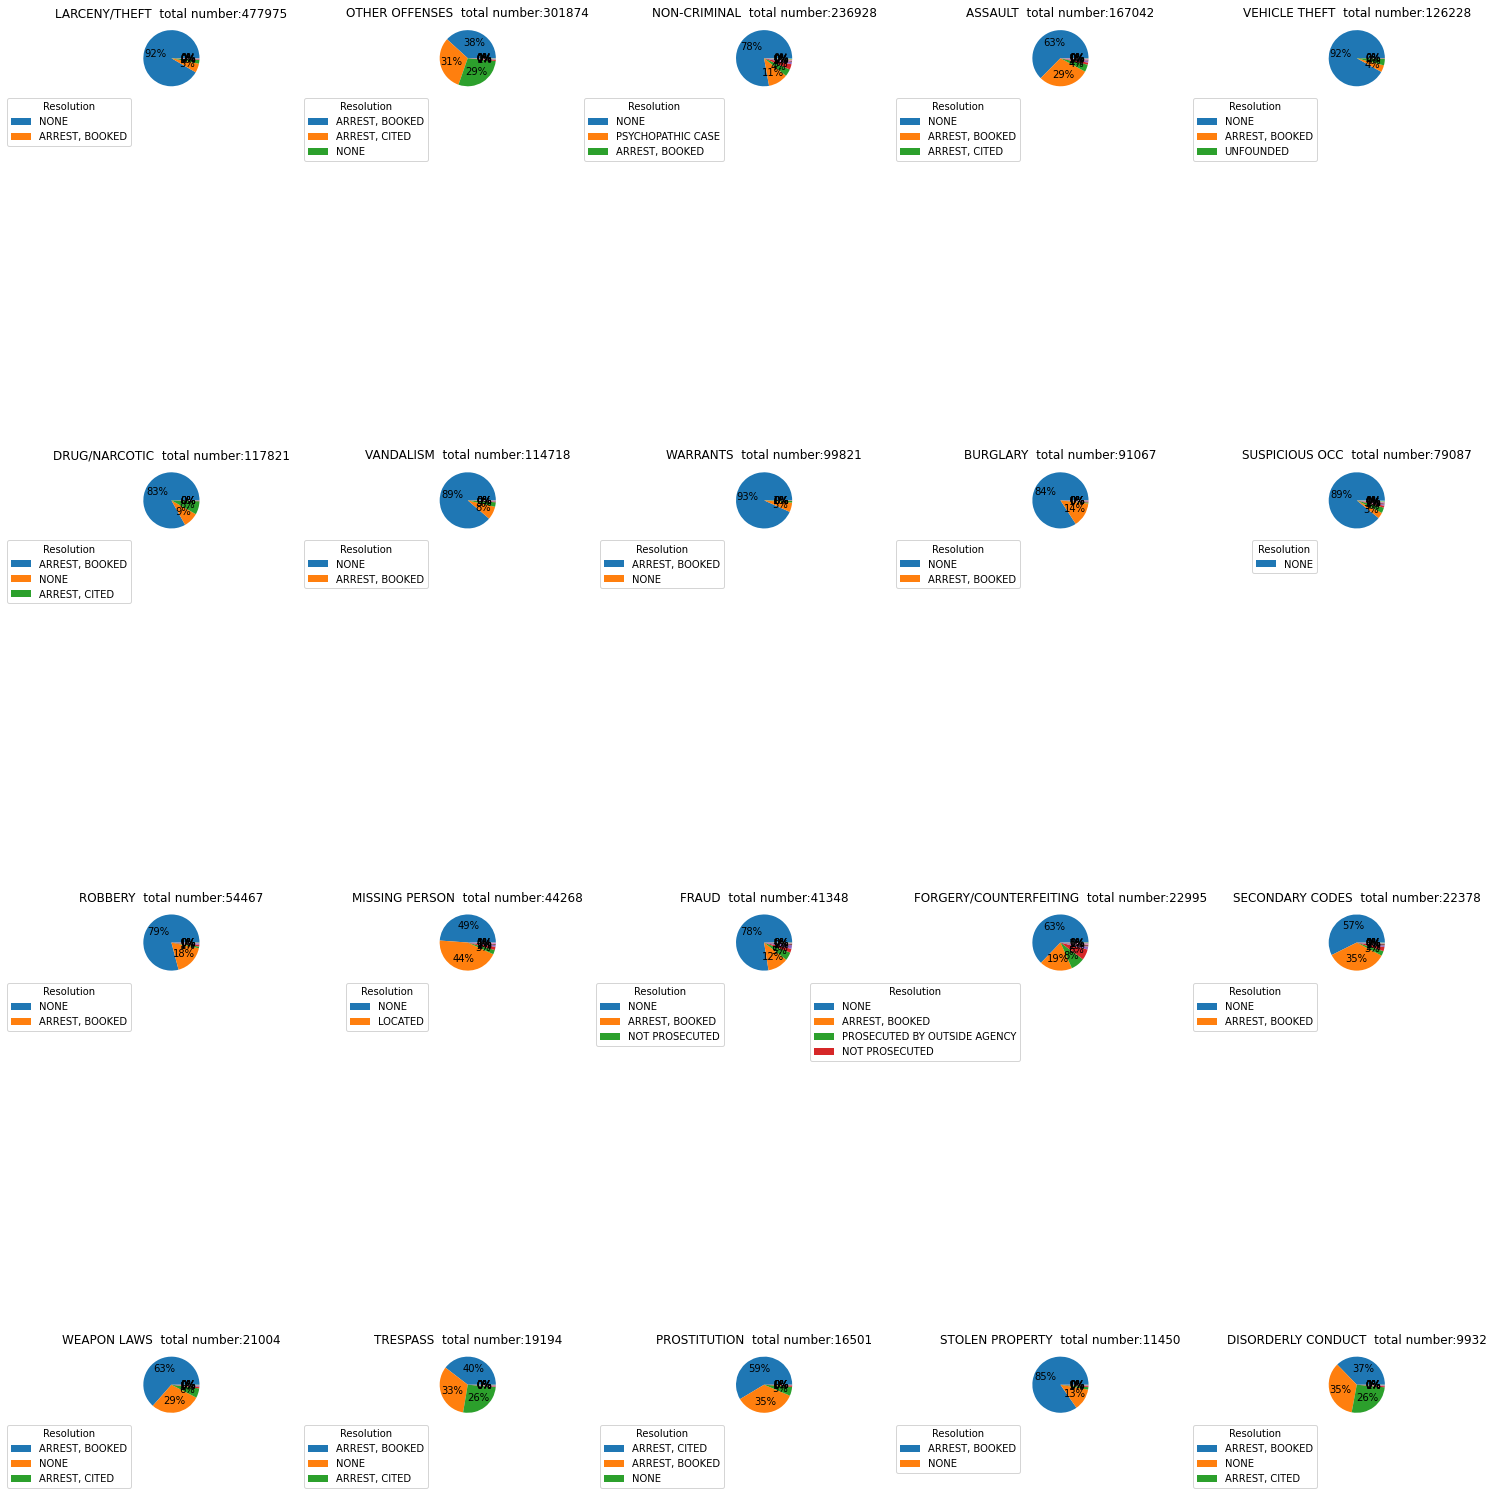

In [0]:
# get all crime categories and their counts in q1
category=[row["Category"] for row in q1.select("Category").collect()]
category_cnt=[row["count"] for row in q1.select("count").collect()]

# give each crime a named dataframe within a dictionary df
thres= 3.5 # filter out resolutions below 3.5%
def autopct_func(pct):
  return ("%1.f%%" %pct) if pct > (thres*0.01) else ""

# select the 20 highest crimes out of 37 crimes
m,n=4,5
cat_dict={}

fig, axes=plt.subplots(m,n, figsize=(20,25))
for i,j in enumerate(category[:m*n]):
  x=df.filter(df.Category ==j).groupBy("Resolution").count().orderBy("count", ascending=False)
  # add percentage column
  x=x.withColumn("percentage", col("count")/category_cnt[i])
  # save Spark Dataframe into the dictionary
  cat_dict[category[i]]=x
  x_pd=x.toPandas()
  
  #select ax for plotting
  temp_ax=axes[i//n, i%n]
  
  # plot every solution + only show autopct text for those pct>thres
  wedges, texts, autotexts= temp_ax.pie(x_pd["count"], autopct=autopct_func)
  temp_ax.set_title(category[i]+"  total number:"+str(category_cnt[i]))
  
  #set labels for each wedge
  xlabels=x.filter(x.percentage>(thres*0.01)).select("Resolution").orderBy("percentage", ascending=False).toPandas()
  
  # set legend with handles and labels
  temp_ax.legend(wedges,xlabels["Resolution"], title="Resolution", loc="upper right", bbox_to_anchor=(0,0))
  
plt.tight_layout()
plt.show()


**Q7 Insights**: <br/>
As illustrated in pie charts above, there are some interesting findings:
* Percentage of None took a dominant role, for almost every category
* None referred to "no resolution", meaning crimes were left unsettled
* Larceny/Theft, being the #1 highest category, had the highest None resolution percentage (92%)

There were also some categories which seemed to be properly handled:
* Other Offenses, being the #2 highest category, had over 60% being arrested, but it was still left with 30% None resolution percentage
* 83% of Drug/Narcotic were arrest, only 9% left with no resolution
* 93% of Warrants were arrested, only 5% left with no resolution
* 63% of Weapon Laws were arrested, but still 30% left without clear resolutions
* 85% of Stolen Property were arrested, leaving 13% unattened

## Final Summarization

This project serves as a demonstration of how Explorative Data Analysis (EDA) works to help data scientists draw insights about key subjects using statistical summary and data visualizations. EDA is an essential step in any analysis project. Not only it enables analysts to swiftly acquire preliminary knowledge about the data in hand, but also helps to clearity what queations to ask next or which tools or models will be useful to dive deep and finally solve the problems. 

**By looking into SF Crime Data from 2003 to 2018, I found that**:
* Larceny/Theft was the #1 crime category**, followed by Other Offenses and Non-Criminal
* Top 3 Most Unsafe Districts are: Southern > Mission > Northern
* SF downtown, as center of the city, had slightly fewer crime incidents on weekends, but relatively high crime cases on Wednesday and Friday
* 2015 witnessed a high increase of crime cases, which got significantly lower in 2018
* Q1 and Q4 (start and end of a year) had higher crime rates, while Q2 and Q3 crimes remained steady and controlled. 
* Christmas and New Year Eve are two big holiday celebration for people around the world. But criminals also know, people immersed themselves in holiday atmosphere and let down their guards at holidays, which could utilized by criminals. 
* On 12/24 and 12/25, crime rates started to increase at 8am when people were getting prepared (e.g. shopping, visiting, celebrating) for Christmas, and reached at its peak at noon (12pm)
* On 12/31, crime rates increased sharply at 8pm when people were waiting for New Year, and reached its highest point on midnight (12am) when people were exhilarating and celeratinng New Year.
* Safest hours during a day were at early morning (1am to 7am)
* Least safest hours during a day were at noon (12pm), midnight (12am) and late afternoon (5pm to 7pm). 
* For almost every crime category, "None" accounted for the highest proportion for its resolution percentages. It should be worrying as it indicated that most of crime cases were left without a clear resolution.
* Some crime categores, however, were mostly handled with clear resolutions, such as Drug/Narcotic (83% arrested), Warrants (93% arrested), Weapon Laws (63% arrested) and Stolen Property (85% arrested). It reveals that SFPD paid higher attention in solving high-severity cases than low-severity cases (e.g. Larcery/Theft, non-criminal)

**I believe SFPD could tackle the issues exposed in previous EDA analysis, improve police distribution efficiency and strengthen safety levels for its citizens and tourists by following these steps**:
* Set more complete polices on arresting criminals, especially in the area of Larceny/Theft, Other Offenses and Non-Criminal as they were the crimes that occured the most.
* Allocate more police forces or police patrol in Southern, Mission and Northern area, especially on Midnight (12am), Noon (12pm) and late afternoon (5pm to 7pm). 
* Advise citizens or tourists to pay additional attention to their belongings or properties on holidays at specific hours, such as morning in 12/24, evening in 12/31 and midnight of 01/01. 
* Strengthen police force in Q1 and Q4 to lower down crime rates